Proyect Description

Beta Bank is experiencing a gradual decline in customers. 

The objective is to study the customers behavioral pattern to predict which clients will leave the bank service soon. 

For that a ML model with maximized F1 score >59% will be made. 

In [119]:
#Libraries setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.impute import KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from  sklearn.model_selection import train_test_split, GridSearchCV
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, auc, recall_score, precision_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [120]:
#Data importing and exploration

#Data importing
churned_data = pd.read_csv("Churn.csv")


#Exploratory Data Analysis
print(churned_data.shape)
print(churned_data.columns)
churned_data.info()
#Exited, IsActiveMember. Review of datatype: they are booleans in integer. 1 or 0. 
print(churned_data["Exited"].head())
print(churned_data["IsActiveMember"].head())

(10000, 14)
Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  Estima

The data has categorical columns that may need to be numerically encoded to be managed in a Machine Learning model. 

Columns: Surname, Geography, Gender.

Tenure column has nan so an imputing action would be of help. 

Data imputation and splitting for ML model training and testing purposes.

In [121]:
#Data splitting 
#60% train, 40% test and validation. 20% each. 
train, test = train_test_split(churned_data, test_size= 0.4, random_state=12345)
valid, test = train_test_split(test, test_size= 0.5, random_state=12345)
#Testing the size of the samples to match the logic of the split
print("Train data size: ", train.shape)
print("Test data size: ", test.shape)
print("Validation data size: ", valid.shape)
print("Correct Data splitting.")

#Split data into target and features
train_target = train["Exited"]
train_features = train.drop(columns=["Exited"])
valid_target = valid["Exited"]
valid_features = valid.drop(columns=["Exited"])
test_target = test["Exited"]
test_features = test.drop(columns=["Exited"])

#Note: Data splitting avoids influencing imputation with values of training data. 



Train data size:  (6000, 14)
Test data size:  (2000, 14)
Validation data size:  (2000, 14)
Correct Data splitting.


In [122]:
#Imputting tenure with the most relevantly fitted registries, advanced imputing. KNN algorithm of imputing. 
#Just Tenure column needs imputting and categorical columns need encoding. 
#ML does not manage well nan or absent data. 
knn_imputer = KNNImputer(n_neighbors=3)
train_features['Tenure'] = knn_imputer.fit_transform(train_features[['Tenure']])
valid_features['Tenure'] = knn_imputer.fit_transform(valid_features[['Tenure']])
test_features['Tenure'] = knn_imputer.fit_transform(test_features[['Tenure']])

#making changes to a function so that it can be applied to several columns: 
class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Nothing needs to be fit here, since LabelEncoder does the job directly.

    def transform(self, X):
        # Apply LabelEncoder to each column
        for column in X.columns:
            le = LabelEncoder()
            X[column] = le.fit_transform(X[column])
        return X

#Preprocessing pipelines
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())            
])

#Encoding of categorical data 
categorical_pipeline = Pipeline([
    ('encoder', LabelEncoderTransformer())                            # Label encoding
])
#preprocessor pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, selector(dtype_exclude='object')),  
        ('cat', categorical_pipeline, selector(dtype_include='object'))  
    ])

#Applying my preprocessor of data to conclude normalization and encoding
train_features_preprocessed = preprocessor.fit_transform(train_features)
train_features_preprocessed = pd.DataFrame(train_features_preprocessed, columns=numerical_columns.tolist() + categorical_columns.tolist())
train_features_preprocessed.info() # The columns need to be reordered according to the original column order of the data. 
column_order = ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
train_features_preprocessed = train_features_preprocessed[column_order]

#Apply the preprocess to validation and test data
valid_features_preprocessed = preprocessor.transform(valid_features)
valid_features_preprocessed = pd.DataFrame(valid_features_preprocessed, columns=numerical_columns.tolist() + categorical_columns.tolist())
valid_features_preprocessed.info() 
valid_features_preprocessed = valid_features_preprocessed[column_order]

test_features_preprocessed = preprocessor.transform(test_features)
test_features_preprocessed = pd.DataFrame(test_features_preprocessed, columns=numerical_columns.tolist() + categorical_columns.tolist())
test_features_preprocessed.info() 
test_features_preprocessed = test_features_preprocessed[column_order]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        6000 non-null   float64
 1   CustomerId       6000 non-null   float64
 2   CreditScore      6000 non-null   float64
 3   Age              6000 non-null   float64
 4   Tenure           6000 non-null   float64
 5   Balance          6000 non-null   float64
 6   NumOfProducts    6000 non-null   float64
 7   HasCrCard        6000 non-null   float64
 8   IsActiveMember   6000 non-null   float64
 9   EstimatedSalary  6000 non-null   float64
 10  Surname          6000 non-null   float64
 11  Geography        6000 non-null   float64
 12  Gender           6000 non-null   float64
dtypes: float64(13)
memory usage: 609.5 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  --

c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\david\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [123]:
#Study the model previous to class balancing by class weight balancing, under or oversampling techniques. So basically data as is which is dominated by clients that have not yet churned while we want to mainly study the characteristics of churned clients. 
rf0_model = RandomForestClassifier(
    n_estimators=100,              # Number of trees
    max_depth=7,                   # Depth of each tree
    random_state=12345,            # For reproducibility
    n_jobs=-1                      # Use all cores to speed up computation
)

# Train the model
rf0_model.fit(train_features_preprocessed, train_target)

# Make predictions on the validation data
valid_predictions = rf0_model.predict(valid_features_preprocessed)

# Evaluate F1 Score
f1 = f1_score(valid_target, valid_predictions)
print(f"F1 Score: {f1}")
print(f"The model has a lower performance than the desired threshold: F1>59%);\nF1:{f1*100}%, status: Failed.")
precision = precision_score(valid_target, valid_predictions)
print(f"The model is high in precision: {precision*100}% appropriate at detecting positive cases that are true positives.") 
recall = recall_score(valid_target, valid_predictions)
print(f"\nThe model detects {recall*100}% of all positive cases therefore low in sensitivity. \nThis metric is highly relevant for the scope of predicting posibility of churning as it states how much churning is detected.")

F1 Score: 0.5197368421052632
The model has a lower performance than the desired threshold: F1>59%);
F1:51.973684210526315%, status: Failed.
The model is high in precision: 83.15789473684211% appropriate at detecting positive cases that are true positives.

The model detects 37.79904306220095% of all positive cases therefore low in sensitivity. 
This metric is highly relevant for the scope of predicting posibility of churning as it states how much churning is detected.


Train a model and test it previous to modifying the data and class weight balancing.

In [124]:
#Study the model performance by class balancing with the argument class_weight. 
rf_model = RandomForestClassifier(
    n_estimators=100,              # Number of trees
    max_depth=7,                   # Depth of each tree
    random_state=12345,            # For reproducibility
    class_weight="balanced",       #This argument allows for equal data classes value. 
    n_jobs=-1                      # Use all cores to speed up computation
)

# Train the model
rf_model.fit(train_features_preprocessed, train_target)

# Make predictions on the validation data
valid_predictions = rf_model.predict(valid_features_preprocessed)

# Evaluate F1 Score
f1 = f1_score(valid_target, valid_predictions)
print(f"F1 Score: {f1}")
print(f"The model performs better than the desired threshold (F1>59%){f1*100}%.")
precision = precision_score(valid_target, valid_predictions)
print(f"The model is {precision*100}% appropriate at detecting positive cases that are true positives.") 
recall = recall_score(valid_target, valid_predictions)
print(f"\nThe model detects {recall*100}% of all positive cases.")

F1 Score: 0.6111111111111112
The model performs better than the desired threshold (F1>59%)61.111111111111114%.
The model is 55.21235521235521% appropriate at detecting positive cases that are true positives.

The model detects 68.42105263157895% of all positive cases.


ROC AUC: 0.7687803579745824


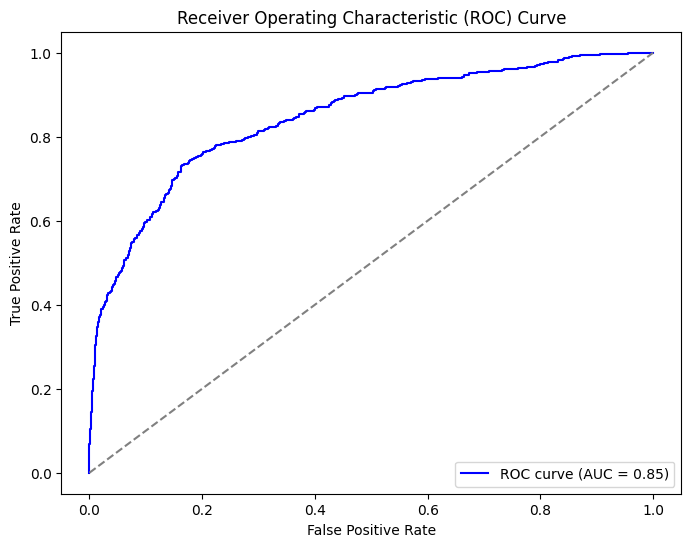

77% class distinction. The model is performing highly in identifying true positives.


In [125]:
# Evaluate ROC AUC of the training dataset in the first model. 
roc_auc = roc_auc_score(valid_target, valid_predictions)
print(f"ROC AUC: {roc_auc}")

# Plot ROC Curve
valid_predict = rf_model.predict_proba(valid_features_preprocessed)[:, 1]
fpr, tpr, thresholds = roc_curve(valid_target, valid_predict) 
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("77% class distinction. The model is performing highly in identifying true positives.")

Class weight exploration

Exited
0    0.800667
1    0.199333
Name: proportion, dtype: float64


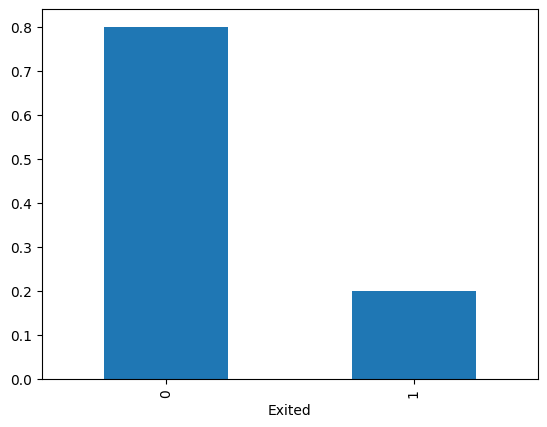

The data consists of 80% non churn registries and roughly 20% clients that have churned.


In [126]:
#Class weight exploration
#In a model having too much of one of the values can be detrimental for the predictions. Asses 0 and 1 representation to get close to 0.5 or at least a .7 to 0.3 with undersample and oversampling techniques. 
class_frequency = train_target.value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind= "bar")
plt.show()
print("The data consists of 80% non churn registries and roughly 20% clients that have churned.")
#80% have not exited yet of the bank. The classes of churned and non churned are not balanced so bringing them to a ratio close to 50% each would help for the purpose of training the model and select a balanced weight. If not the model may generalize as having a bias towards predicting the class that repeats the most. 

Undersampling to balance the classes of churned and non churned clients

In [127]:
#Defining an undersampling function
def random_undersample(df, target_column, random_state=None):
    """
    Performs random undersampling to balance the classes in a target column.

    Parameters:
    - df (pd.DataFrame): the DataFrame containing the data.
    - target_column (str): the name of the target column (class label).
    - random_state (int, optional): seed for reproducibility.

    Returns:
    - balanced_df (pd.DataFrame): DataFrame with balanced classes via undersampling.
    """
    # Get the minimum number of samples among all classes
    min_count = df[target_column].value_counts().min()
    
    # Random undersampling for each class
    balanced_dfs = []
    for class_label, group in df.groupby(target_column):
        undersampled_group = group.sample(n=min_count, random_state=random_state)
        balanced_dfs.append(undersampled_group)
    
    # Combine the balanced subsets
    balanced_df = pd.concat(balanced_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return balanced_df

#Calling the function on the training churn dataset.
train_concat = pd.concat([train_features_preprocessed, train_target], axis= 1)
train_balanced_undersampling = random_undersample(train_concat, "Exited",random_state= 12345)

#splitting into features and target 
train_balanced_undersampling_target = train_balanced_undersampling["Exited"]
train_balanced_undersampling_features = train_balanced_undersampling.drop(columns="Exited")


Test the model after undersampling

In [128]:
rf2_model = RandomForestClassifier(
    n_estimators=100,              # Number of trees
    max_depth=5,                   # Depth of each tree
    class_weight= "balanced", 
    random_state=12345,            # For reproducibility
    n_jobs=-1                      # Use all cores to speed up computation
)

# Train the model
rf2_model.fit(train_balanced_undersampling_features, train_balanced_undersampling_target)

# Make predictions on the validation data
valid_predictions = rf2_model.predict(valid_features_preprocessed)

# Evaluate F1 Score
f1 = f1_score(valid_target, valid_predictions)
print(f"F1 Score: {f1}")
print("The F1 metric reduced significantly after undersampling much lower than the acceptable F1 threshold.")
#Precision vs Recall balance. Which one is more relevant for this project? 
precision = precision_score(valid_target, valid_predictions)
print(f"The model is {precision*100}% appropriate at detecting positive cases that are true positives.") 
recall = recall_score(valid_target, valid_predictions)
print(f"\nThe model detects {recall*100}% of all positive cases.")
print(f"\nThe model is less precise but detects {recall}% of churning clients.")

#Further delve into the model metrics to review its performance in detail regarding churning prediction. 

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(valid_target, rf_model.predict_proba(valid_features_preprocessed)[:, 1])
roc_auc = auc(fpr, tpr)


F1 Score: 0.2831215970961887
The F1 metric reduced significantly after undersampling much lower than the acceptable F1 threshold.
The model is 18.947368421052634% appropriate at detecting positive cases that are true positives.

The model detects 55.980861244019145% of all positive cases.

The model is less precise but detects 0.5598086124401914% of churning clients.


Oversampling

In [129]:
def random_oversample(df, target_column, random_state=None):
    """
    Performs random oversampling to balance the classes in a target column.

    Parameters:
    - df (pd.DataFrame): the DataFrame containing the data.
    - target_column (str): the name of the target column (class label).
    - random_state (int, optional): seed for reproducibility.

    Returns:
    - df_balanced (pd.DataFrame): DataFrame with classes balanced through oversampling.
    """
    # Get the maximum number of samples among the classes
    max_count = df[target_column].value_counts().max()
    
    # Random oversampling per class
    balanced_dfs = []
    for class_value, group in df.groupby(target_column):
        # Repeat with replacement until reaching the maximum count
        oversampled_group = group.sample(n=max_count, replace=True, random_state=random_state)
        balanced_dfs.append(oversampled_group)
    
    # Combine the balanced subsets
    df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return df_balanced

In [130]:
#Calling the function on the training churn dataset.
train_concat = pd.concat([train_features_preprocessed, train_target], axis= 1)
train_balanced_oversampling = random_oversample(train_concat, "Exited",random_state= 12345)

#splitting into features and target 
train_balanced_oversampling_target = train_balanced_oversampling["Exited"]
train_balanced_oversampling_features = train_balanced_oversampling.drop(columns="Exited")

In [131]:
#Testing the model on the oversampled training data
rf3_model = RandomForestClassifier(
    n_estimators=100,              # Number of trees
    max_depth=5,                   # Depth of each tree
    class_weight= "balanced", 
    random_state=12345,            # For reproducibility
    n_jobs=-1                      # Use all cores to speed up computation
)
# Train the model
rf3_model.fit(train_balanced_oversampling_features, train_balanced_oversampling_target)

# Make predictions on the validation data
valid_predictions = rf3_model.predict(valid_features_preprocessed)

# Evaluate F1 Score
f1 = f1_score(valid_target, valid_predictions)
print(f"F1 Score: {f1}")
print("The F1 metric reduced significantly after oversampling in comparison to regular class weight balancing much lower than the acceptable threshold.")
#Precision vs Recall balance. Which one is more relevant for this project? 
precision = precision_score(valid_target, valid_predictions)
print(f"The model is {precision*100}% appropriate at detecting positive cases that are true positives.") 
recall = recall_score(valid_target, valid_predictions)
print(f"\nThe model detects {recall*100}% of all positive cases.")
print(f"\nThe model has a weak performance in precision and recall.")

F1 Score: 0.3442265795206972
The F1 metric reduced significantly after oversampling in comparison to regular class weight balancing much lower than the acceptable threshold.
The model is 24.713242961418143% appropriate at detecting positive cases that are true positives.

The model detects 56.698564593301434% of all positive cases.

The model has a weak performance in precision and recall.


The ML model performed better using regular class weight balancing than regular under or oversampling techniques.

Cluster centroids or synthetic training data points using smote can be made to further improve the model as well as further fine tunning of hyperparameters. 

Reruning the best performing model with the test data to explore the degree of model consistency. 

Will the model give similar results?

F1 Score: 0.5939139559286464
The model is able to predict true false and true positives with a close consistency of the same f1 score of 57.6% assertiveness. Lower than desired threshold of 59%.

The model is 53.39622641509434% appropriate at detecting positive cases that are true positives.

The model detects 66.903073286052% of all positive cases.
ROC AUC: 0.84606586105527


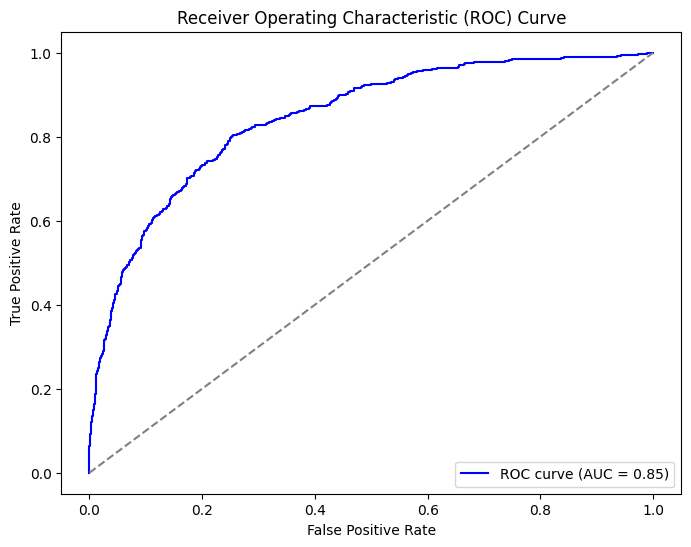

The model has 85% assertiveness distinguishing between true positives in new data and is therefore considered a strong model at detecting possibility of churning. 
The model shows consistency in f1 score ~59.4% and remains greater than the initially stated threshold.


In [132]:
#Check on test data to review consistency of the model 
test_predictions = rf_model.predict(test_features_preprocessed)

# Evaluate F1 Score
f1 = f1_score(test_target, test_predictions)
print(f"F1 Score: {f1}")
print("The model is able to predict true false and true positives with a close consistency of the same f1 score of 57.6% assertiveness. Lower than desired threshold of 59%.")

#Precision vs Recall exploration in test data.  
precision = precision_score(test_target, test_predictions)
print(f"\nThe model is {precision*100}% appropriate at detecting positive cases that are true positives.") 
recall = recall_score(test_target, test_predictions)
print(f"\nThe model detects {recall*100}% of all positive cases.")

#Further delve into the model metrics to review its performance in detail regarding churning prediction. 

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(test_target, rf_model.predict_proba(test_features_preprocessed)[:, 1])
roc_auc = auc(fpr, tpr)

#Reviewing cosistency of ROC-AUC with the validation data. 
print(f"ROC AUC: {roc_auc}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
print("The model has 85% assertiveness distinguishing between true positives in new data and is therefore considered a strong model at detecting possibility of churning. \nThe model shows consistency in f1 score ~59.4% and remains greater than the initially stated threshold.")


Conclusions

A model was trained with and without sampling techniques (undersampling and oversampling). Regular balancing of the data with the argument class_weight = "balanced" gave the best performance.

The model F1 or precission and recall balance ranges from ~59% to ~61% showing consistency in the results when using new data and having ~85% true positive detection according to the area under the curve. 

Especial advise: 

Following the objective of the enterprise to maximize for clients that will likely churn, lowering the detection threshold of churning at the expense of reducing the precision and therefore the F1 metric could be advantageous. 

Lowering the threshold would reduce precision by making more positive predictions. Great for the purpose of predicting clients close to churning and reduce the distinguishing ability between classes of the model at the advantage of being more sensitive to the possibility of churning. 

Threshold reduction could be lowered as much as required to predict positive as needed according to the reach and investment desired by the decision makers of the company. 